In [ ]:
import numpy as np # linear algebra
import pandas as pd

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_data_path = '/content/drive/MyDrive/Cardiomegaly/train/train'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [ ]:
train_df['label'].value_counts()

,count
label,
true,2229
false,2219


In [ ]:
test_data_path = '/content/drive/MyDrive/Cardiomegaly/test/test'

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [ ]:
test_df['label'].value_counts()

,count
label,
false,567
true,567


In [ ]:
valid,test = train_test_split(test_df,train_size= 0.5,shuffle=True,random_state=42)

In [ ]:
img_size = (224,224)
batch_size = 16


tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 4448 validated image filenames belonging to 2 classes.
Found 567 validated image filenames belonging to 2 classes.
Found 567 validated image filenames belonging to 2 classes.


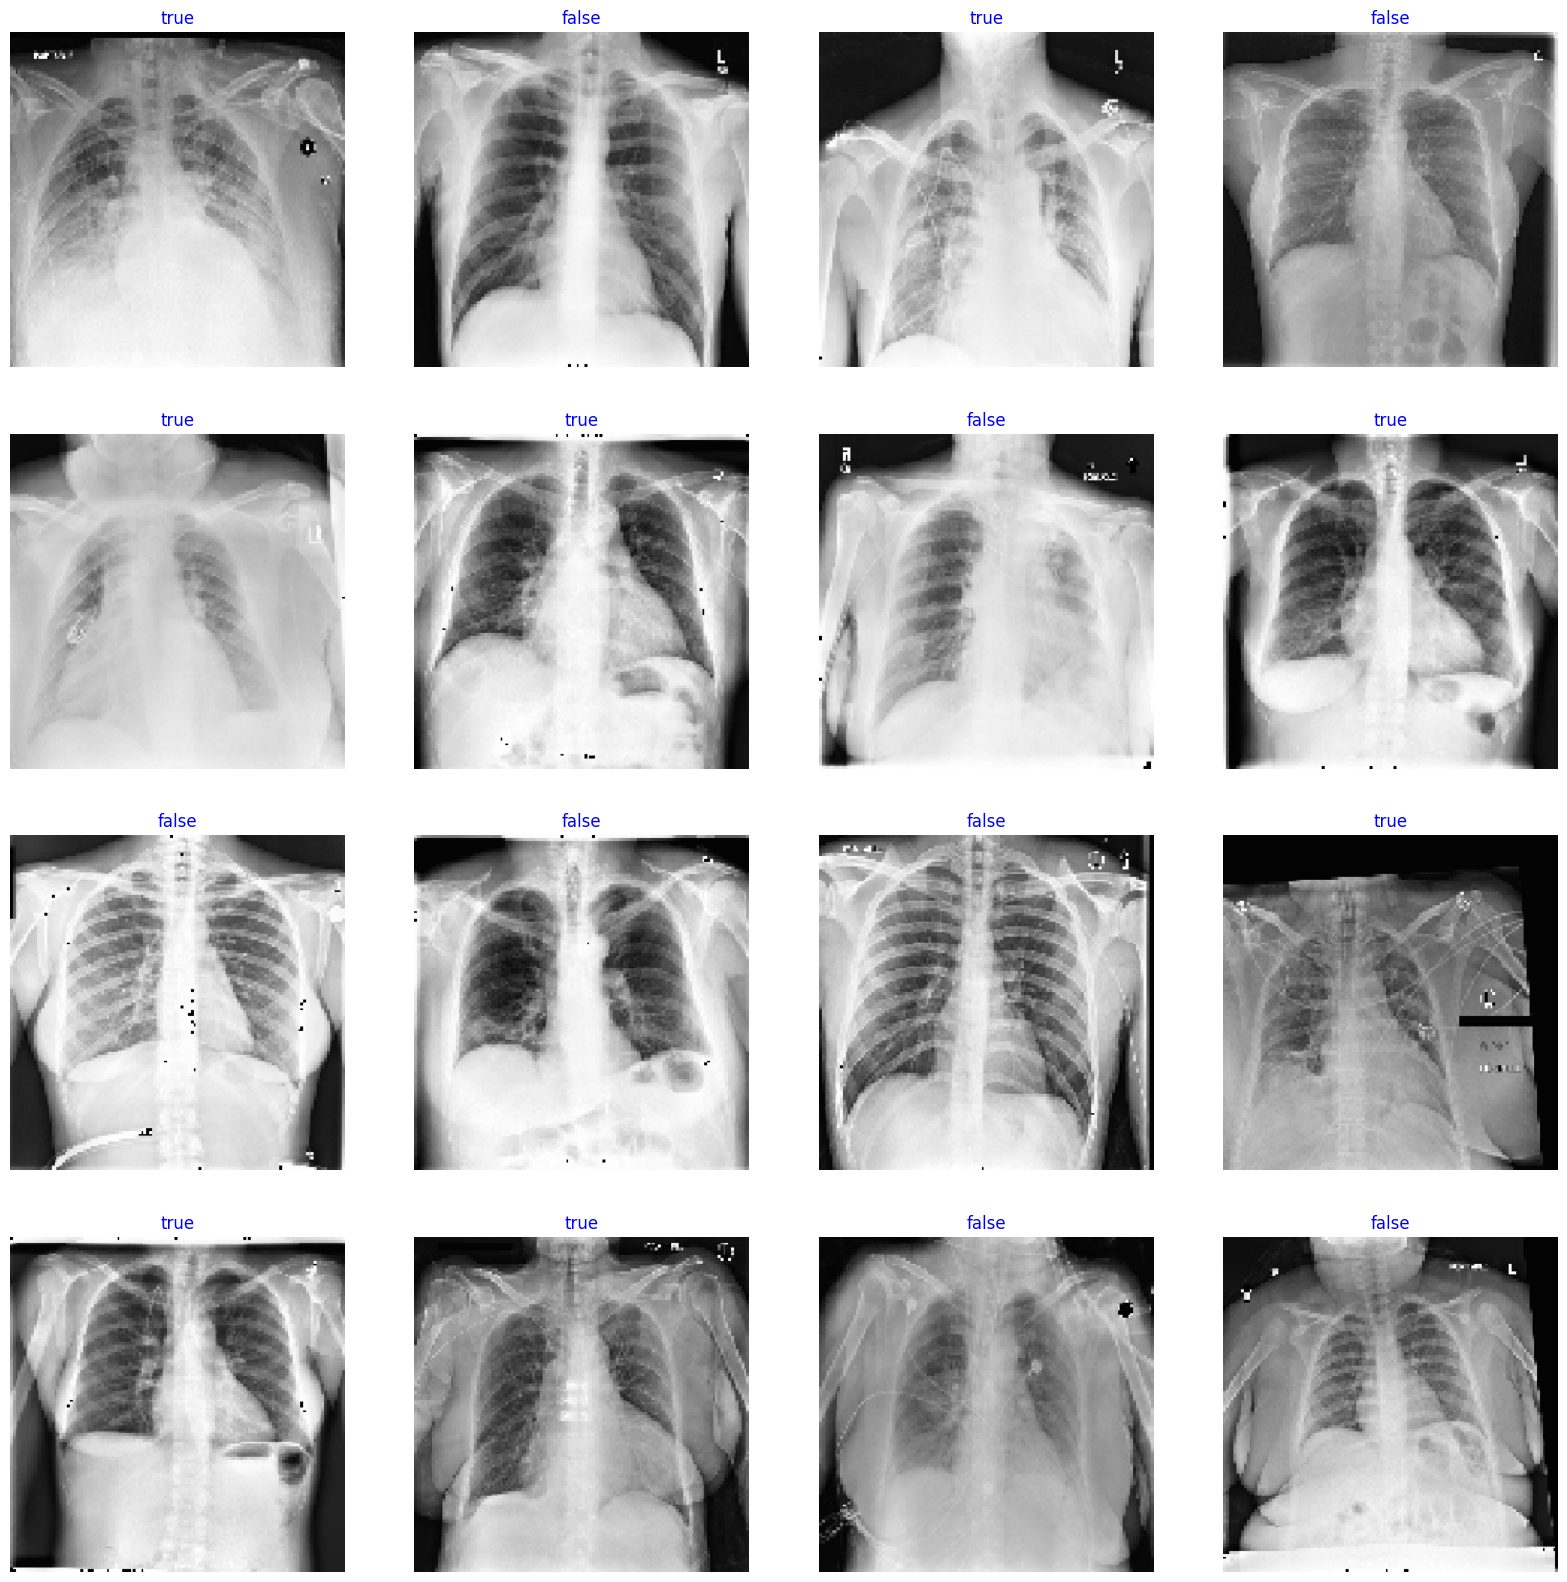

In [ ]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

In [ ]:
pip install --upgrade tensorflow


In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (BatchNormalization, Dense, Dropout,
                                     GlobalAveragePooling2D, Input, Add)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


img_size = (224, 224)
classes = list(gen_dict.keys())
num_class = len(classes)

img_shape = (img_size[0], img_size[1], 3)

inputs = Input(shape=img_shape)


base_model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet',
                                                   input_shape=img_shape, pooling=None)(inputs)


base_model.trainable = False


x = GlobalAveragePooling2D()(base_model)


x = Dense(512, kernel_regularizer=regularizers.l2(0.016), activation='relu')(x)
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dropout(rate=0.5)(x)

x = Dense(256, kernel_regularizer=regularizers.l2(0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dropout(rate=0.4)(x)

def residual_block(x, units):
    residual = x
    x = Dense(units, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(units)(x)
    x = Add()([x, residual])
    x = tf.keras.layers.Activation('relu')(x)
    return x

x = residual_block(x, 256)
x = residual_block(x, 256)

# Adding Two More Dense Layers
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.3)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

outputs = Dense(num_class, activation='softmax')(x)


model = Model(inputs=inputs, outputs=outputs)


lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                  patience=3,
                                  verbose=1,
                                  factor=0.5,
                                  min_lr=1e-6)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)


model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb7            │ (None, 7, 7, 2560)     │     64,097,687 │ input_layer[0][0]      │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2560)           │              0 │ efficientnetb7[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      1,311,232 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512)            │          2,048 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256)            │          1,024 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │         65,792 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256)            │          1,024 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │         65,792 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense_3[0][0],         │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256)            │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │         65,792 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256)            │          1,024 │ dense_4[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 65,849,817 (251.20 MB)

 Trainable params: 65,536,530 (250.00 MB)

 Non-trainable params: 313,287 (1.20 MB)

In [ ]:
history = model.fit(
    x=train_gen,
    epochs=120,
    verbose=1,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=False,
    callbacks=[lr_reduction, early_stopping]
)


test_loss, test_accuracy = model.evaluate(valid_gen, steps=valid_gen.samples // valid_gen.batch_size)
print(f"Test Accuracy: {test_accuracy:.4f}")



Epoch 1/120
278/278 ━━━━━━━━━━━━━━━━━━━━ 2086s 7s/step - accuracy: 0.5057 - loss: 27.4792 - val_accuracy: 0.4727 - val_loss: 18.9576 - learning_rate: 0.0010
Epoch 2/120
278/278 ━━━━━━━━━━━━━━━━━━━━ 68s 243ms/step - accuracy: 0.5203 - loss: 15.5404 - val_accuracy: 0.4903 - val_loss: 24.8136 - learning_rate: 0.0010
Epoch 3/120
278/278 ━━━━━━━━━━━━━━━━━━━━ 68s 245ms/step - accuracy: 0.5099 - loss: 12.3812 - val_accuracy: 0.5273 - val_loss: 45.7635 - learning_rate: 0.0010
Epoch 4/120
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.4950 - loss: 9.8464
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
278/278 ━━━━━━━━━━━━━━━━━━━━ 68s 243ms/step - accuracy: 0.4950 - loss: 9.8445 - val_accuracy: 0.4727 - val_loss: 25.4348 - learning_rate: 0.0010
Epoch 5/120
278/278 ━━━━━━━━━━━━━━━━━━━━ 68s 245ms/step - accuracy: 0.5080 - loss: 7.9849 - val_accuracy: 0.5273 - val_loss: 11.3247 - learning_rate: 5.0000e-04
Epoch 6/120
278/278 ━━━━━━━━━━━━━━━━━━━━ 68s 246ms/step 

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

In [ ]:
print(train_acc[-1])

0.9577338099479675


In [ ]:
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8268


In [ ]:
# Save model weights
model.save_weights('efficientnet.weights.h5')

In [ ]:
from google.colab import files

# Download the file
files.download('efficientnet.weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

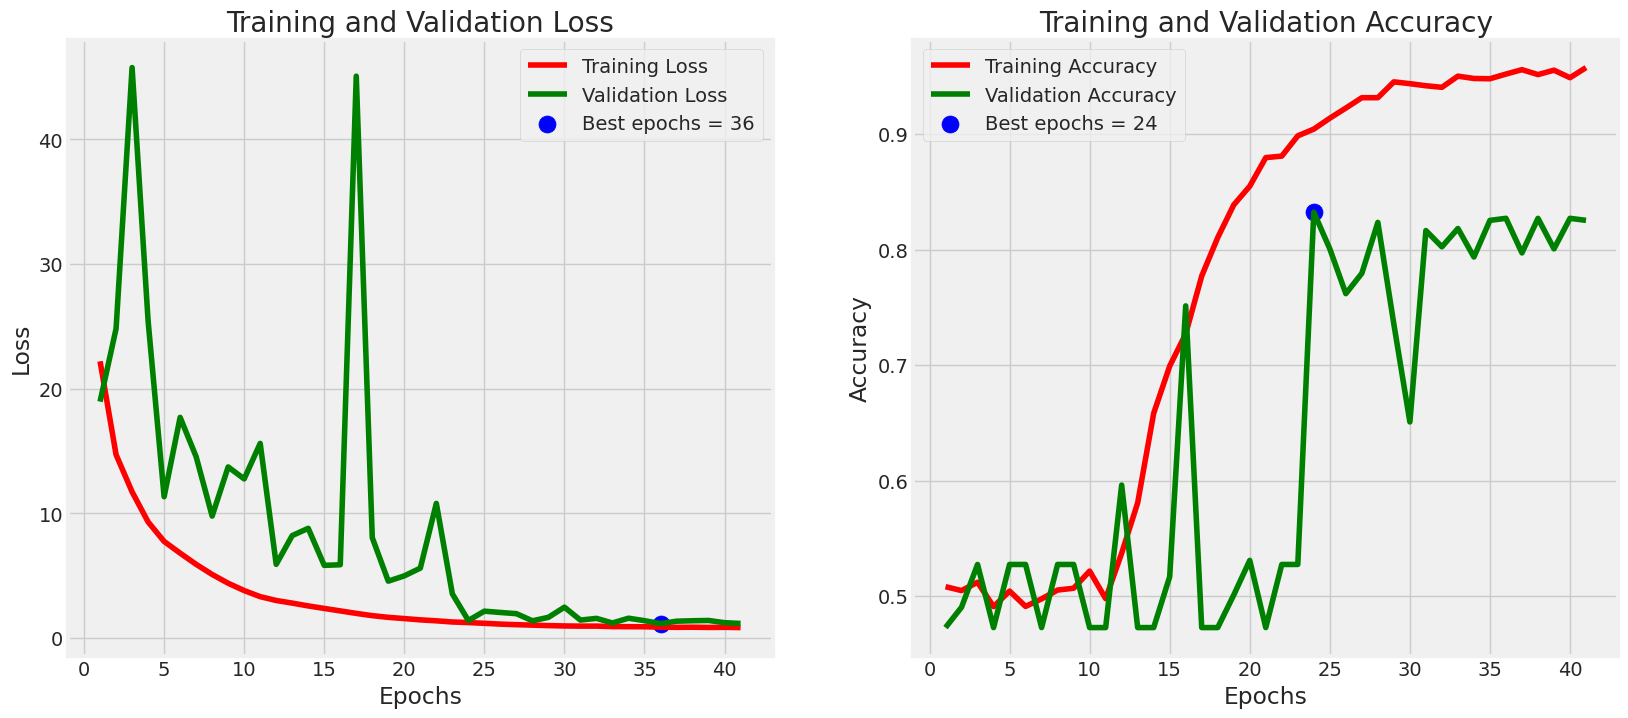

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [ ]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds , axis = 1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 234s 6s/step


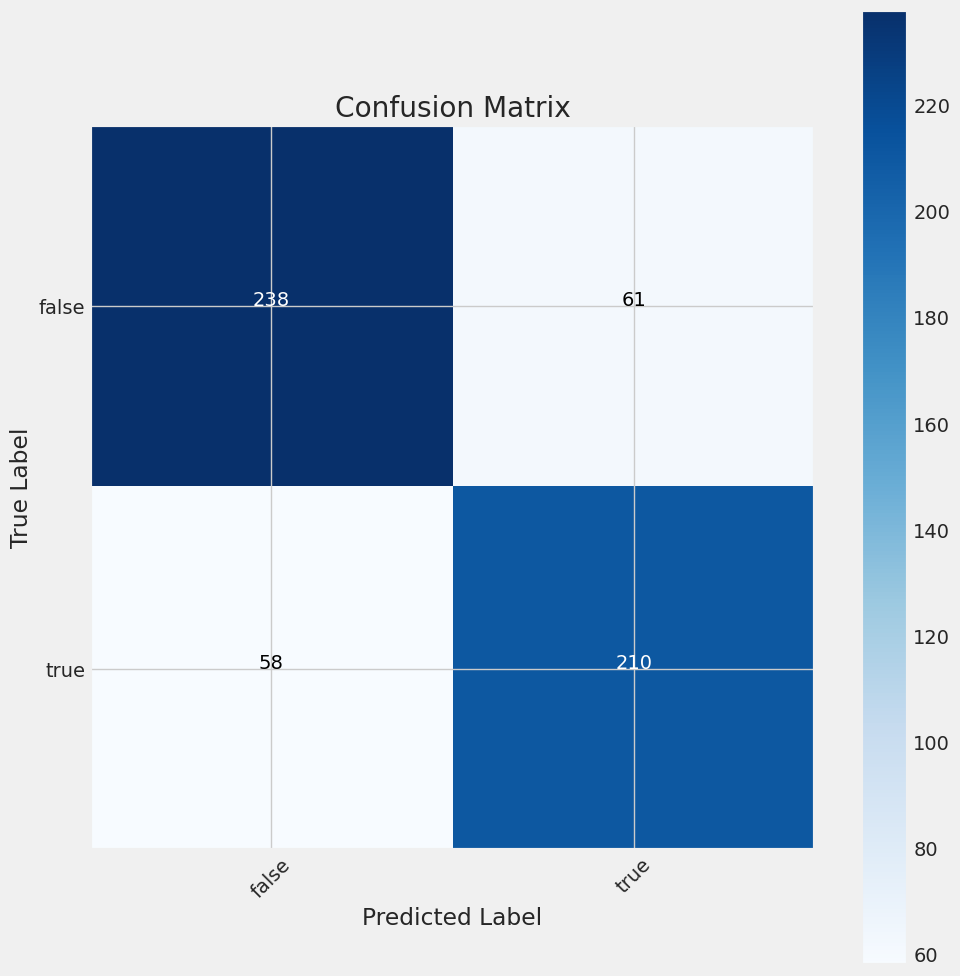

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 0.7934
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8532 - loss: 1.1433
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7230 - loss: 1.3174
Train Loss:  0.8019698858261108
Train Accuracy:  1.0
--------------------
Validation Loss:  1.1469625234603882
Validation Accuracy:  0.83203125
--------------------
Test Loss:  1.215895652770996
Test Accuracy:  0.78125


In [ ]:
# Inference function
def preprocess_image(image_path, target_size):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

def predict_image(image_path, model, classes):
    img = preprocess_image(image_path, img_size)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions, axis=1)[0]
    class_name = classes[predicted_class]
    return class_name

# Example usage
sample_image_path = '/content/drive/MyDrive/Cardiomegaly/test/test/false/109.png'  # Replace with your sample image path
predicted_class = predict_image(sample_image_path, model, classes)
print(f'The predicted class for the sample image is: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
The predicted class for the sample image is: false


In [ ]:
# Example usage
sample_image_path = '/content/drive/MyDrive/Cardiomegaly/test/test/true/106.png'  # Replace with your sample image path
predicted_class = predict_image(sample_image_path, model, classes)
print(f'The predicted class for the sample image is: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
The predicted class for the sample image is: true


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate precision, recall, and F1 score for each class
precision = precision_score(test_gen.classes, y_pred, average=None, labels=list(gen_dict.values()))
recall = recall_score(test_gen.classes, y_pred, average=None, labels=list(gen_dict.values()))
f1 = f1_score(test_gen.classes, y_pred, average=None, labels=list(gen_dict.values()))

# Calculate the confusion matrix again for reference
cm = confusion_matrix(test_gen.classes, y_pred)

# Calculate specificity and sensitivity for each class
def calculate_sensitivity(cm):
    sensitivity = np.diag(cm) / np.sum(cm, axis=1)
    return sensitivity

def calculate_specificity(cm):
    specificity = np.sum(cm) - np.sum(cm, axis=0) - np.sum(cm, axis=1) + np.diag(cm)
    specificity = specificity / (np.sum(cm) - np.sum(cm, axis=0))
    return specificity

sensitivity = calculate_sensitivity(cm)
specificity = calculate_specificity(cm)

# Print all statistics
print("Precision for each class: ", precision)
print("Recall (Sensitivity) for each class: ", recall)
print("F1 Score for each class: ", f1)
print("Specificity for each class: ", specificity)
print("Sensitivity for each class: ", sensitivity)

# Optionally, calculate macro and micro averages
precision_macro = np.mean(precision)
recall_macro = np.mean(recall)
f1_macro = np.mean(f1)

precision_micro = precision_score(test_gen.classes, y_pred, average='micro')
recall_micro = recall_score(test_gen.classes, y_pred, average='micro')
f1_micro = f1_score(test_gen.classes, y_pred, average='micro')

print("Macro Average Precision: ", precision_macro)
print("Macro Average Recall: ", recall_macro)
print("Macro Average F1 Score: ", f1_macro)
print("Micro Average Precision: ", precision_micro)
print("Micro Average Recall: ", recall_micro)
print("Micro Average F1 Score: ", f1_micro)

Precision for each class:  [0.80405405 0.77490775]
Recall (Sensitivity) for each class:  [0.79598662 0.78358209]
F1 Score for each class:  [0.8        0.77922078]
Specificity for each class:  [0.77490775 0.80405405]
Sensitivity for each class:  [0.79598662 0.78358209]
Macro Average Precision:  0.7894809015657724
Macro Average Recall:  0.7897843558129087
Macro Average F1 Score:  0.7896103896103897
Micro Average Precision:  0.7901234567901234
Micro Average Recall:  0.7901234567901234
Micro Average F1 Score:  0.7901234567901234


In [ ]:
print(classification_report(test_gen.classes, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       299
           1       0.77      0.78      0.78       268

    accuracy                           0.79       567
   macro avg       0.79      0.79      0.79       567
weighted avg       0.79      0.79      0.79       567

